## Regularización de pesos

Dentro de las muchas técnicas de regularización existen tres que han sido importadas de la [regresión robusta](https://en.wikipedia.org/wiki/Robust_regression): la regularización **Ridge**, **Lasso** y **ElasticNet.**

Estas regularizaciones provienen del análisis de datos atípicos en regresiones, donde un conjunto de datos puede tener ruido y errores pero no se desean tomar en cuenta. Este tipo de regularizaciones están basados en las normas espaciales $L_1$, $L_2$ y $L_1-L_2$, respectivamente.

Durante la búsqueda de metodologías que pudieran mejorar los resultados de clasificaciones de redes neuronales muy profundas surgió la idea de emplear este tipo de regularizadores, lo que resultó en una excelente idea que mejora mucho el resultado, además de que reduce el sobreajuste de las redes neuronales.

En este documento se exploran los tres tipos de regularización junto con algunas metodologías adicionales para verificar su eficacia en redes neuronales, sobre todo redes neuronales convolucionales (CNN).

In [21]:
from keras.datasets import fashion_mnist
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, GaussianNoise
from keras.utils import to_categorical
from keras.models import Sequential
from keras import regularizers
from keras.optimizers import SGD
import matplotlib.pyplot as plt

## Fashion-MNIST

El conjunto de datos empleado es el [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que tiene 10 clases, cada una pertenece a un tipo de prenda o de calzado. La idea de este conjunto de datos (en realidad son imágenes) es que sirva como un reemplazo para el famoso conjunto de datos de dígitos escritos a mano del MNIST.

Las imágenes tienen un tamaño de $28 \times 28$ y están en tono de grises.

In [22]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [23]:
# Tamaño de lote para el optimizador
batch_size = 128
# Número de clases, ya se sabe por que se conoce el conjunto de datos
# pero si no, se puede hacer de forma programática
num_classes = 10
# Número de épocas, dejar como está porque es suficiente
epocas = 50
# Parámetro de regularización L2 (Ridge)
regular_param_l2 = 1e-4
# Parámetro de regularización L1 (Lasso)
regular_param_l1 = 5e-5

# Tamaño de las imágenes, ancho y alto
img_rows, img_cols = 28, 28

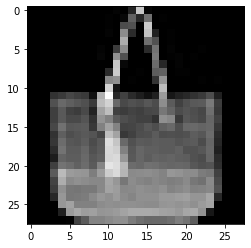

In [24]:
# Se puede visualizar una de estas imágenes para conocer el conjunto de datos
plt.imshow(x_train[35, :, :], cmap="gray")

In [25]:
# Reajustar las imágenes para asegurar que solamente es un canal de color
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# Tamaño de la entrada, en forma de tupla siempre
input_shape = (img_rows, img_cols, 1)

In [26]:
# Convertir a float32 para mejor manejo
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Normalizar los valores de las imágenes
x_train /= 255
x_test /= 255

In [27]:
print("Tamaño del conjunto de entrenamiento:", x_train.shape)
print(x_train.shape[0], "Muestras de entrenamiento")
print(x_test.shape[0], "Muestras de prueba")

Tamaño del conjunto de entrenamiento: (60000, 28, 28, 1)
60000 Muestras de entrenamiento
10000 Muestras de prueba


In [28]:
# Codificación One Hot para las etiquetas
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Arquitecturas de las CNN

Todas las arquitecturas tienen la misma forma en común, que proviene del [ejemplo de `keras`](https://keras.io/examples/cifar10_cnn/) para la clasificación del conjunto de datos CIFAR-10, solamente que en este caso se emplea otro conjunto de datos como ya se ha explicado anteriormente.

Sin embargo, para cada caso se modificará la arquitectura, específicamente:

- La **primera** arquitectura consta de regularizadores en las capas de convolución y totalmente conectadas. El regularizador empleado es de tipo $L_2$ (Ridge).

- La **segunda** arquitectura consta de regularizadores en las capas de convolución y totalmente conectadas. El regularizador empleado es de tipo $L_1$ (Lasso).

- La **tercera** arquitectura consta de regularizadores en las capas de convolución y totalmente conectadas. El regularizador empleado es de tipo $L_1$ y $L_2$ (ElasticNet).

In [29]:
# Con regularizador L2
arquitectura_l2 = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:],
          kernel_regularizer=regularizers.l2(regular_param_l2)),
    Activation("relu"),
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(regular_param_l2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regularizers.l2(regular_param_l2)),
    Activation("relu"),
    Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(regular_param_l2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l2(regular_param_l2)),
    Dropout(0.5),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [30]:
# Con regularizador L1
arquitectura_l1 = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:],
          kernel_regularizer=regularizers.l1(regular_param_l1)),
    Activation("relu"),
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1(regular_param_l1)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regularizers.l1(regular_param_l1)),
    Activation("relu"),
    Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1(regular_param_l1)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l1(regular_param_l1)),
    Dropout(0.5),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [31]:
# Con regularizador L1 y L2
arquitectura_l1_l2 = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:],
          kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    Conv2D(32, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3), padding="same",
          kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    Conv2D(64, (3, 3), kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, kernel_regularizer=regularizers.l1_l2(l1=regular_param_l1, l2=regular_param_l2)),
    Dropout(0.5),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

In [32]:
modelo_l2 = Sequential(arquitectura_l2)
modelo_l1 = Sequential(arquitectura_l1)
modelo_l1_l2 = Sequential(arquitectura_l1_l2)

## Optimización y entrenamiento

Todas las arquitecturas serán entrenadas con descenso de gradiente estocástico con ratio de aprendizaje 0.001 y momento clásico de 0.9.

El entrenamiento será validado con el 20% de ejemplos del conjunto de entrenamiento, y después será evaluado con el conjunto de prueba que se separó al principio, en el preprocesamiento de datos.

In [33]:
modelo_l2.compile(loss="categorical_crossentropy",
                 optimizer=SGD(lr=0.001, momentum=0.9),
                 metrics=["accuracy"])
historia_l2 = modelo_l2.fit(x_train, y_train, batch_size=batch_size,
             epochs=epocas,
             validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 60s 1ms/step - loss: 1.9116 - acc: 0.3334 - val_loss: 1.0247 - val_acc: 0.6803
Epoch 2/50
48000/48000 [==============================] - 57s 1ms/step - loss: 1.0563 - acc: 0.6372 - val_loss: 0.8127 - val_acc: 0.7413
Epoch 3/50
48000/48000 [==============================] - 58s 1ms/step - loss: 0.8831 - acc: 0.7015 - val_loss: 0.7263 - val_acc: 0.7638
Epoch 4/50
48000/48000 [==============================] - 58s 1ms/step - loss: 0.8059 - acc: 0.7329 - val_loss: 0.6825 - val_acc: 0.7828
Epoch 5/50
48000/48000 [==============================] - 57s 1ms/step - loss: 0.7523 - acc: 0.7513 - val_loss: 0.6495 - val_acc: 0.7906
Epoch 6/50
48000/48000 [==============================] - 58s 1ms/step - loss: 0.7166 - acc: 0.7647 - val_loss: 0.6186 - val_acc: 0.7967
Epoch 7/50
48000/48000 [==============================] - 58s 1ms/step - loss: 0.6898 - acc: 0.7762 - val_loss: 0.5917 - val_acc

In [36]:
modelo_l2.evaluate(x_test, y_test)

10000/10000 [==============================] - 6s 558us/step


[0.38824188022613526, 0.891]

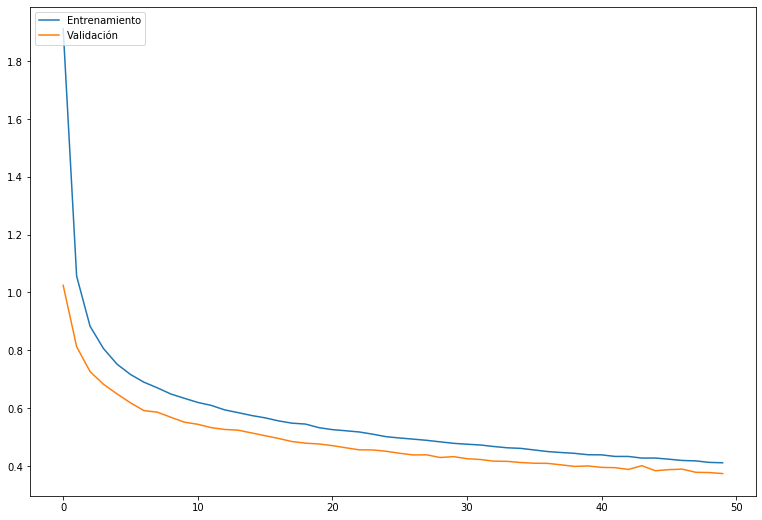

In [37]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia_l2.history['loss'])
plt.plot(historia_l2.history['val_loss'])
plt.legend(["Entrenamiento", "Validación"], loc='upper left')
plt.show()

Como se puede ver, junto con _dropout_ y regularización de pesos $L_2$ la red neuronal controla muy bien el sobreajuste. Adicionalmente, la precisión que resulta es buena, y algo importante a notar es que la precisión en el conjunto de validación es mayor que en el conjunto de entrenamiento. Esto es algo normal e incluso esperado, este es el tipo de comportamiento que se debe observar cuando se aplica este tipo de regularización.

In [34]:
modelo_l1.compile(loss="categorical_crossentropy",
                 optimizer=SGD(lr=0.001, momentum=0.9),
                 metrics=["accuracy"])
historia_l1 = modelo_l1.fit(x_train, y_train, batch_size=batch_size,
             epochs=epocas,
             validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 62s 1ms/step - loss: 3.2791 - acc: 0.2278 - val_loss: 2.3303 - val_acc: 0.6140
Epoch 2/50
48000/48000 [==============================] - 61s 1ms/step - loss: 2.3021 - acc: 0.5940 - val_loss: 1.9854 - val_acc: 0.7309
Epoch 3/50
48000/48000 [==============================] - 60s 1ms/step - loss: 2.0575 - acc: 0.6793 - val_loss: 1.8729 - val_acc: 0.7535
Epoch 4/50
48000/48000 [==============================] - 59s 1ms/step - loss: 1.9484 - acc: 0.7150 - val_loss: 1.8218 - val_acc: 0.7697
Epoch 5/50
48000/48000 [==============================] - 59s 1ms/step - loss: 1.8797 - acc: 0.7370 - val_loss: 1.7665 - val_acc: 0.7817
Epoch 6/50
48000/48000 [==============================] - 60s 1ms/step - loss: 1.8325 - acc: 0.7534 - val_loss: 1.7320 - val_acc: 0.7911
Epoch 7/50
48000/48000 [==============================] - 62s 1ms/step - loss: 1.7909 - acc: 0.7658 - val_loss: 1.6890 - val_acc

In [38]:
modelo_l1.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 494us/step


[1.1564080490112305, 0.8893]

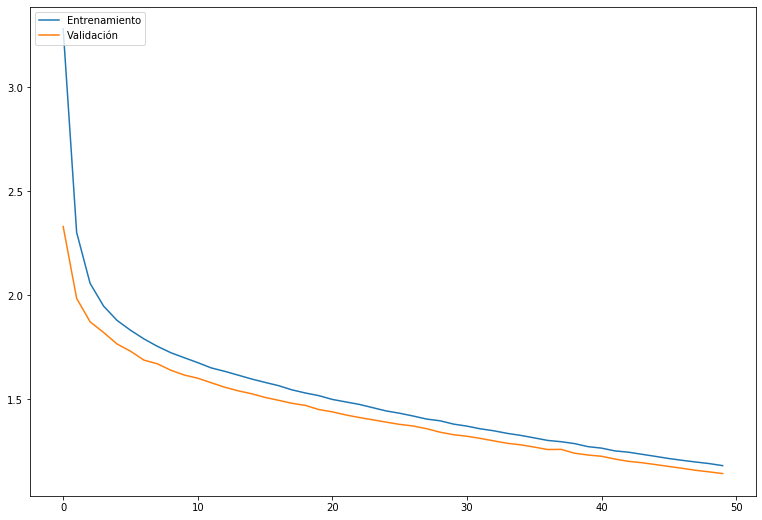

In [39]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia_l1.history['loss'])
plt.plot(historia_l1.history['val_loss'])
plt.legend(["Entrenamiento", "Validación"], loc='upper left')
plt.show()

Esta regularización tipo $L_1$ tiene mucho potencial dado que se puede observar en la gráfica que el error puede seguir disminuyendo si se le otorgara más tiempo de entrenamiento. Se debe recordar que la regularización _Lasso_ permite distinguir entre las características importantes y no importantes dentro de un conjunto de datos, por lo que además de controlar el sobreajuste aún tiene un potencial para mejorar el valor de precisión en la clasificación.

In [35]:
modelo_l1_l2.compile(loss="categorical_crossentropy",
                 optimizer=SGD(lr=0.001, momentum=0.9),
                 metrics=["accuracy"])
historia_l1_l2 = modelo_l1_l2.fit(x_train, y_train, batch_size=batch_size,
             epochs=epocas,
             validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 60s 1ms/step - loss: 3.3027 - acc: 0.2855 - val_loss: 2.3302 - val_acc: 0.6517
Epoch 2/50
48000/48000 [==============================] - 61s 1ms/step - loss: 2.3178 - acc: 0.6189 - val_loss: 2.0295 - val_acc: 0.7408
Epoch 3/50
48000/48000 [==============================] - 58s 1ms/step - loss: 2.0985 - acc: 0.6983 - val_loss: 1.9281 - val_acc: 0.7628
Epoch 4/50
48000/48000 [==============================] - 60s 1ms/step - loss: 1.9973 - acc: 0.7304 - val_loss: 1.8720 - val_acc: 0.7773
Epoch 5/50
48000/48000 [==============================] - 60s 1ms/step - loss: 1.9334 - acc: 0.7497 - val_loss: 1.8177 - val_acc: 0.7949
Epoch 6/50
48000/48000 [==============================] - 59s 1ms/step - loss: 1.8844 - acc: 0.7671 - val_loss: 1.7765 - val_acc: 0.8070
Epoch 7/50
48000/48000 [==============================] - 61s 1ms/step - loss: 1.8439 - acc: 0.7771 - val_loss: 1.7413 - val_acc

In [41]:
modelo_l1_l2.evaluate(x_test, y_test)

10000/10000 [==============================] - 5s 476us/step


[1.1699292415618896, 0.8924]

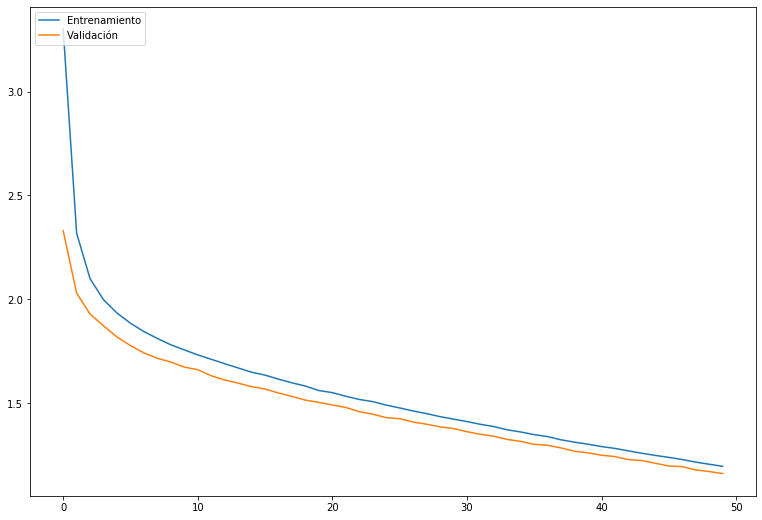

In [40]:
# Graficar los valores de pérdida en el entrenamiento
plt.figure(figsize=(13, 9))
plt.plot(historia_l1_l2.history['loss'])
plt.plot(historia_l1_l2.history['val_loss'])
plt.legend(["Entrenamiento", "Validación"], loc='upper left')
plt.show()

Al combinar los dos métodos el sobreajuste es mínimo y además, debido a la regularización de tipo $L_1$ esta arquitectura aún tiene potencial para mejorar su valor de precisión en la clasificación. Sin embargo no siempre es necesario aplicar este tipo de regularización _ElasticNet_ y depende mucho del tipo de datos con el que se esté trabajando.

## Conclusiones

La regularización de pesos es una de las técnicas más utilizadas en Deep Learning en la actualidad, sin embargo es importante tomar en cuenta que agregar este tipo de metodologías aumentan los hiperparámetros a ajustar en las redes neuronales. Esto puede ser contraproducente e incluso imposible en redes neuronales muy grandes, pero en muchas situaciones este tipo de regularizadores son obligatorios para mejorar la precisión del modelo.